In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

### Explore Dataset

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

In [ ]:
train = pd.read_csv('/content/Train_heart_disease_uci.csv')
test = pd.read_csv('/content/Test_heart_disease_uci.csv')
train.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,223,39,Female,Cleveland,non-anginal,94.0,199.0,False,normal,179.0,False,0.0,upsloping,0.0,normal,0.0
1,850,48,Male,VA Long Beach,asymptomatic,NaN,272.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,749,56,Male,VA Long Beach,asymptomatic,120.0,100.0,False,normal,120.0,True,1.5,flat,0.0,reversable defect,1.0
3,421,51,Female,Hungary,non-anginal,110.0,190.0,False,normal,120.0,False,0.0,NaN,NaN,NaN,0.0
4,312,33,Male,Hungary,non-anginal,120.0,298.0,False,normal,185.0,False,0.0,NaN,NaN,NaN,0.0


In [ ]:
#info
train.info()
# Check for missing values
print(train.isnull().sum())

print(train.duplicated().sum())

# Get dimension of dataset
print(train.shape)

# Get basic statistics
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        690 non-null    int64  
 1   age       690 non-null    int64  
 2   sex       690 non-null    object 
 3   dataset   690 non-null    object 
 4   cp        690 non-null    object 
 5   trestbps  648 non-null    float64
 6   chol      669 non-null    float64
 7   fbs       622 non-null    object 
 8   restecg   688 non-null    object 
 9   thalch    652 non-null    float64
 10  exang     652 non-null    object 
 11  oldpeak   648 non-null    float64
 12  slope     470 non-null    object 
 13  ca        236 non-null    float64
 14  thal      327 non-null    object 
 15  num       481 non-null    float64
dtypes: float64(6), int64(2), object(8)
memory usage: 86.4+ KB
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     42
chol         21
fbs          68
re

## Clean Data

In [ ]:
train.drop(columns=['id', 'dataset'], inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import pandas as pd

num_cols = ['trestbps', 'chol', 'thalch', 'oldpeak']
cat_cols = ['fbs', 'restecg', 'exang', 'slope', 'thal']

# Median for numerical values
num_imputer = SimpleImputer(strategy='median')
train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols] = num_imputer.transform(test[num_cols])

# Scale the numerical columns
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# Convert 'fbs' and 'exang' to 0 and 1 and fill missing with mode
for col in ['fbs', 'exang']:
    train[col] = train[col].fillna(train[col].mode()[0]).astype(int)
    test[col] = test[col].fillna(test[col].mode()[0]).astype(int)

# Mode for nominal categories (restecg)
train['restecg'] = train['restecg'].fillna(train['restecg'].mode()[0])
test['restecg'] = test['restecg'].fillna(test['restecg'].mode()[0])

# Label Encoding & KNN Imputation for 'slope'
label_encoder = LabelEncoder()
train['slope'] = label_encoder.fit_transform(train['slope'].fillna('Unknown'))
test['slope'] = label_encoder.transform(test['slope'].fillna('Unknown'))
knn_imputer = KNNImputer(n_neighbors=5)
train[['slope']] = knn_imputer.fit_transform(train[['slope']])
test[['slope']] = knn_imputer.transform(test[['slope']])

# One-Hot Encoding for nominal categorical columns (restecg, slope, thal, sex)
encoder = OneHotEncoder( sparse_output=False)

# Apply encoding to the train and test datasets
encoded_cols_train = encoder.fit_transform(train[['restecg', 'slope', 'thal', 'sex']])
encoded_cols_test = encoder.transform(test[['restecg', 'slope', 'thal', 'sex']])

# Convert to DataFrame and concatenate with the original dataset
encoded_df_train = pd.DataFrame(encoded_cols_train, columns=encoder.get_feature_names_out())
encoded_df_test = pd.DataFrame(encoded_cols_test, columns=encoder.get_feature_names_out())

# Drop original columns and concatenate the encoded ones
train = pd.concat([train.drop(columns=['restecg', 'slope', 'thal', 'sex']), encoded_df_train], axis=1)
test = pd.concat([test.drop(columns=['restecg', 'slope', 'thal', 'sex']), encoded_df_test], axis=1)

# Handling 'cp' (Chest Pain Type) as an Ordinal Feature
cp_mapping = {'typical angina': 1, 'atypical angina': 2, 'non-anginal': 3, 'asymptomatic': 4}
train['cp'] = train['cp'].map(cp_mapping)
test['cp'] = test['cp'].map(cp_mapping)



<ipython-input-627-ecbe5e3ce032>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[col] = train[col].fillna(train[col].mode()[0]).astype(int)
<ipython-input-627-ecbe5e3ce032>:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[col] = test[col].fillna(test[col].mode()[0]).astype(int)
<ipython-input-627-ecbe5e3ce032>:66: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('futu

In [ ]:
train.head(100)

,age,cp,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,...,slope_0.0,slope_1.0,slope_2.0,slope_3.0,thal_fixed defect,thal_normal,thal_reversable defect,thal_nan,sex_Female,sex_Male
0,39,3,-2.036739,-0.002265,0,1.641738,0,-0.836523,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,48,4,-0.101958,0.664930,0,0.080802,0,-0.269249,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,56,4,-0.639397,-0.907092,0,-0.719678,1,0.581661,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,51,3,-1.176836,-0.084522,0,-0.719678,0,-0.836523,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,33,3,-0.639397,0.902562,0,1.881883,0,-0.836523,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,58,2,-0.101958,0.281064,0,0.481042,0,-0.836523,NaN,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
96,51,4,0.435482,0.911701,0,1.401594,1,0.676206,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
97,51,2,1.510360,-0.047963,0,1.281522,0,-0.836523,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
98,52,3,0.220506,-0.029684,0,1.241498,0,-0.741977,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
train.isnull().sum()

,0
age,0
cp,0
trestbps,0
chol,0
fbs,0
thalch,0
exang,0
oldpeak,0
ca,454
num,209


In [ ]:
# check how ca is related to other attributes so we can find the most suitable way to fill missing values in ca
correlation_ca = train.corr(numeric_only=True)['ca'].sort_values(ascending=False)
print(correlation_ca)

ca                          1.000000
num                         0.437706
age                         0.324158
oldpeak                     0.304122
cp                          0.204201
thal_reversable defect      0.201527
slope_2.0                   0.168278
fbs                         0.150556
restecg_lv hypertrophy      0.137701
exang                       0.102863
trestbps                    0.099426
sex_Male                    0.094382
thal_fixed defect           0.055692
chol                        0.043454
restecg_st-t abnormality    0.042433
thal_nan                    0.023476
slope_1.0                  -0.007706
slope_0.0                  -0.064370
sex_Female                 -0.094382
restecg_normal             -0.151926
slope_3.0                  -0.152791
thal_normal                -0.231299
thalch                     -0.245362
Name: ca, dtype: float64


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Features for prediction (use non-missing predictors to predict 'ca')
features = ['age', 'thalch', 'oldpeak']  # You can add other relevant features if necessary

# Splitting known and unknown parts of 'ca' in the train dataset
df_known_ca = train[train['ca'].notnull()]
df_missing_ca = train[train['ca'].isnull()]

X_known_ca = df_known_ca[features]
y_known_ca = df_known_ca['ca']

# Using Gradient Boosting Regressor to predict missing 'ca' values in the train dataset
gbm_imputer_ca = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
gbm_imputer_ca.fit(X_known_ca, y_known_ca)

# Predict missing 'ca' values in the train dataset
X_missing_ca = df_missing_ca[features]
predicted_ca_train = gbm_imputer_ca.predict(X_missing_ca)

# Fill the missing 'ca' values in the train dataset
train.loc[train['ca'].isnull(), 'ca'] = predicted_ca_train

# Handling missing 'ca' values in the test dataset
df_missing_ca_test = test[test['ca'].isnull()]

# Ensure predictions only happen for rows with missing 'ca'
if len(df_missing_ca_test) > 0:
    X_missing_ca_test = df_missing_ca_test[features]

    # Predict missing 'ca' values in the test dataset using the model trained on the train dataset
    predicted_ca_test = gbm_imputer_ca.predict(X_missing_ca_test)

    # Ensure the length of predicted_ca_test matches the number of missing values in test['ca']
    if len(predicted_ca_test) == len(df_missing_ca_test):
        # Fill the missing 'ca' values in the test dataset
        test.loc[test['ca'].isnull(), 'ca'] = predicted_ca_test
    else:
        print(f"Prediction length mismatch in test: {len(predicted_ca_test)} != {len(df_missing_ca_test)}")
else:
    print("No missing values found for 'ca' in the test dataset.")

# Verify that missing values in 'ca' are filled in both datasets
print("Missing values in 'ca' after filling in train:", train['ca'].isnull().sum())  # Should print 0
print("Missing values in 'ca' after filling in test:", test['ca'].isnull().sum())  # Should print 0


Missing values in 'ca' after filling in train: 0
Missing values in 'ca' after filling in test: 0


In [ ]:
train.isnull().sum()

,0
age,0
cp,0
trestbps,0
chol,0
fbs,0
thalch,0
exang,0
oldpeak,0
ca,0
num,209


In [ ]:
train.head()

,age,cp,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,...,slope_0.0,slope_1.0,slope_2.0,slope_3.0,thal_fixed defect,thal_normal,thal_reversable defect,thal_nan,sex_Female,sex_Male
0,39,3,-2.036739,-0.002265,0,1.641738,0,-0.836523,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,48,4,-0.101958,0.664930,0,0.080802,0,-0.269249,0.221356,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,56,4,-0.639397,-0.907092,0,-0.719678,1,0.581661,0.000000,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,51,3,-1.176836,-0.084522,0,-0.719678,0,-0.836523,0.073857,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,33,3,-0.639397,0.902562,0,1.881883,0,-0.836523,0.006193,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Outliers

In [ ]:
import numpy as np

# Identify continuous numerical columns (excluding categorical and binary)
continuous_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()


    return outliers

# Detect outliers only in continuous numerical columns
outliers_iqr = detect_outliers_iqr(train, continuous_cols)
print("Outliers detected in continuous numerical columns:", outliers_iqr)

Outliers detected in continuous numerical columns: {'age': np.int64(0), 'trestbps': np.int64(22), 'chol': np.int64(141), 'thalch': np.int64(3), 'oldpeak': np.int64(13), 'ca': np.int64(22)}


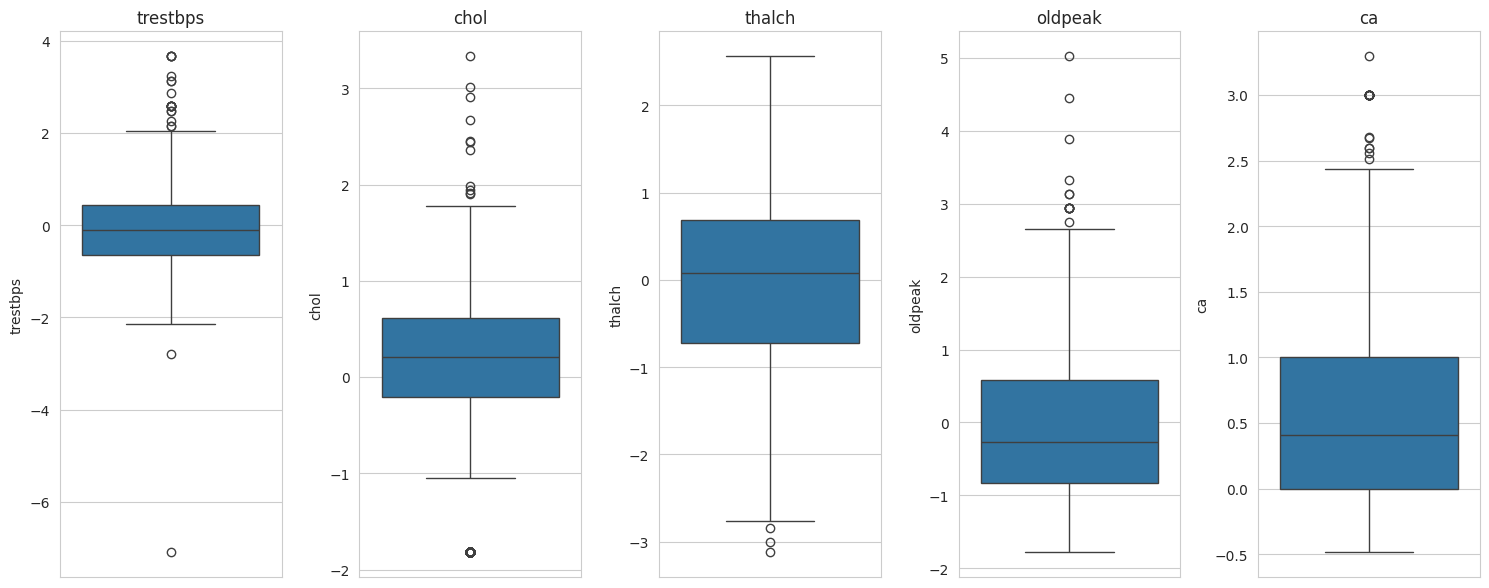

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define columns with detected outliers
outlier_columns = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Set up the figure size
plt.figure(figsize=(15, 6))

# Create box plots
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(1, len(outlier_columns), i)  # Create subplots
    sns.boxplot(y=train[col])
    plt.title(col)

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Count entries where 'chol' is negative or zero
invalid_chol_count = (train['chol'] <= 0).sum()

# Print the result
print(f"Number of entries with negative or zero cholesterol: {invalid_chol_count}")

# Compute median excluding invalid values
median_chol = train[train['chol'] > 0]['chol'].median()

# Replace invalid values with median
train.loc[train['chol'] <= 0, 'chol'] = median_chol


Number of entries with negative or zero cholesterol: 230


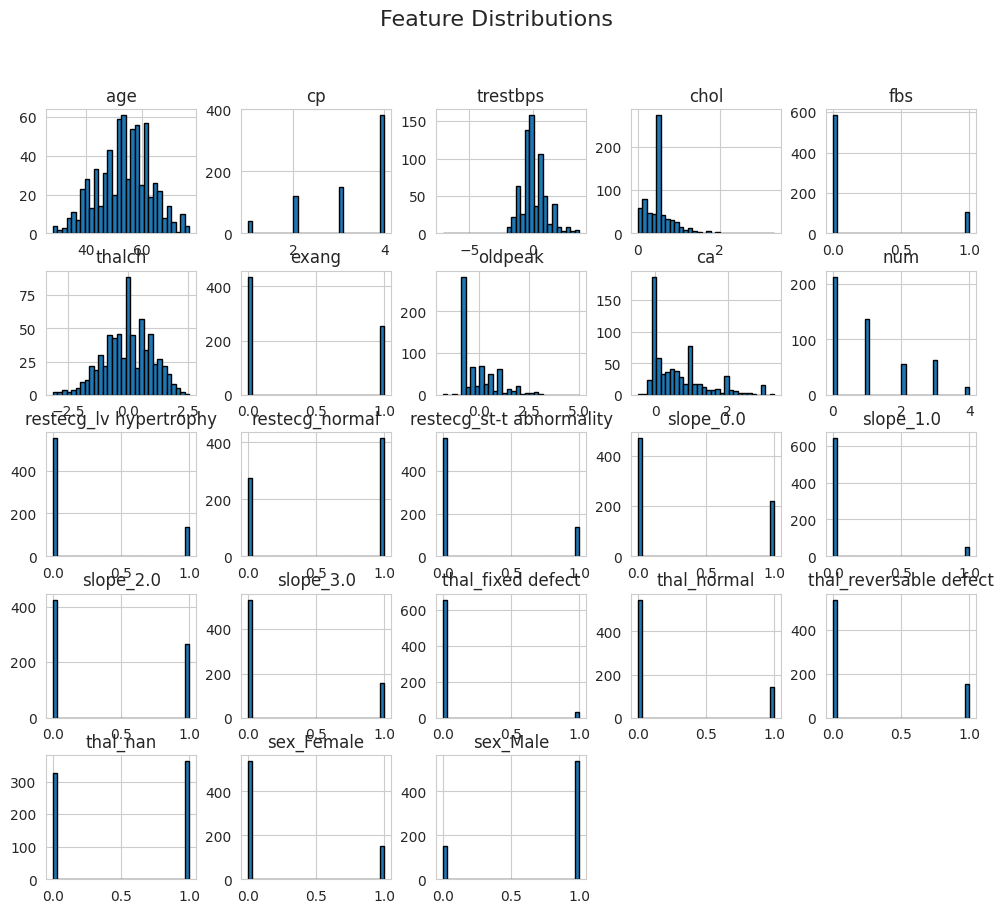

In [ ]:
# 1. Histograms for Feature Distributions
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

train.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

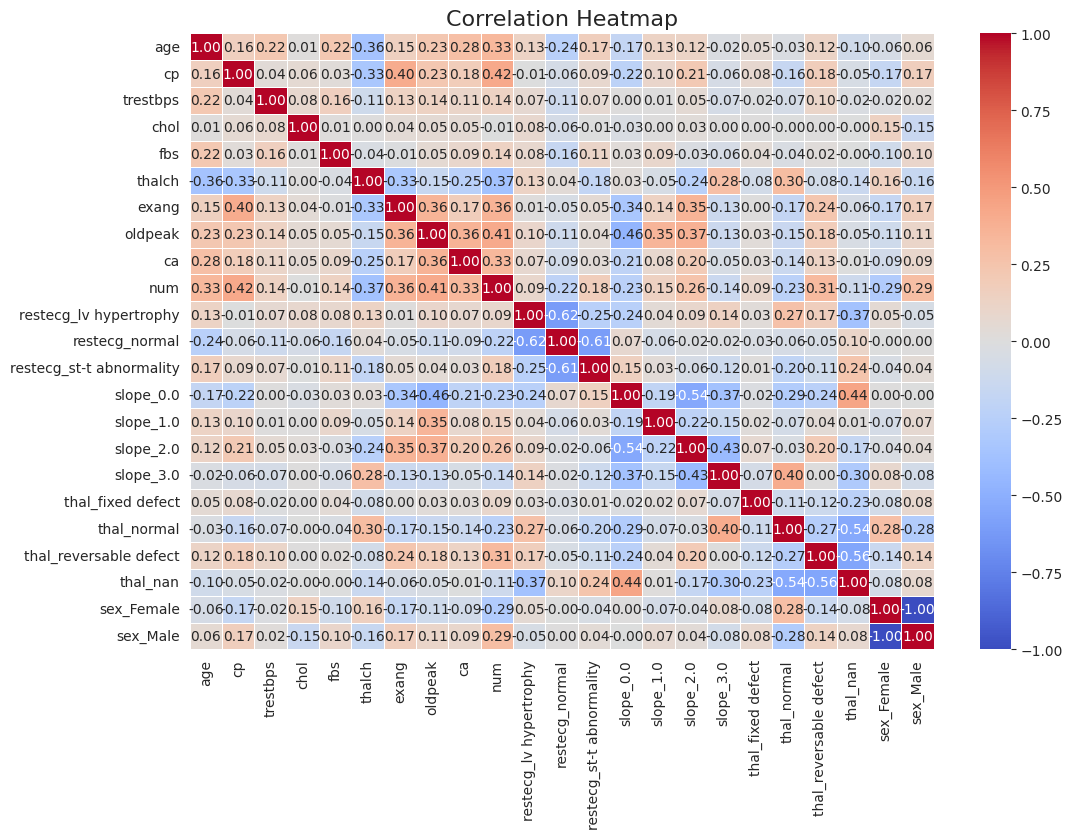

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### Prepare Data for models and choose the best model

In [ ]:
!pip install scikit-fuzzy

In [ ]:
print(train.columns)

Index(['age', 'cp', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak',
       'ca', 'num', 'restecg_lv hypertrophy', 'restecg_normal',
       'restecg_st-t abnormality', 'slope_0.0', 'slope_1.0', 'slope_2.0',
       'slope_3.0', 'thal_fixed defect', 'thal_normal',
       'thal_reversable defect', 'thal_nan', 'sex_Female', 'sex_Male'],
      dtype='object')


In [ ]:
bool_columns = ['restecg_normal', 'restecg_st-t abnormality', 'thal_fixed defect', 'thal_normal', 'thal_reversable defect']

train[bool_columns] = train[bool_columns].astype(int)

In [ ]:
train.columns

Index(['age', 'cp', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak',
       'ca', 'num', 'restecg_lv hypertrophy', 'restecg_normal',
       'restecg_st-t abnormality', 'slope_0.0', 'slope_1.0', 'slope_2.0',
       'slope_3.0', 'thal_fixed defect', 'thal_normal',
       'thal_reversable defect', 'thal_nan', 'sex_Female', 'sex_Male'],
      dtype='object')

In [ ]:
def robust_cluster_impute_num(train):
    """
    Robust clustering-based imputation for missing 'num' values
    Handles cases where there might be no complete cases
    """

    # 1. Select relevant features (excluding 'num' to prevent data leakage)
    features = [
        'age', 'cp', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak',
        'ca', 'restecg_normal', 'restecg_st-t abnormality',  'thal_fixed defect', 'thal_normal',
       'thal_reversable defect','slope_1.0',
        'slope_2.0', 'slope_3.0',  'sex_Male'
    ]


    # Create working copy
    df = train.copy()
    X = df[features].values

    # 2. Get indices of missing 'num' values
    missing_idx = df[df['num'].isna()].index
    complete_idx = df[~df['num'].isna()].index

    # Check if we have any complete cases to learn from
    if len(complete_idx) == 0:
        print("Warning: No complete cases found. Using simple imputation instead.")
        df['num'] = df['num'].fillna(df['num'].mode()[0])
        return df

    # 3. Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. Dimensionality Reduction
    pca = PCA(n_components=0.95, random_state=42)
    X_reduced = pca.fit_transform(X_scaled)

    # 5. Determine number of clusters from existing 'num' values
    n_clusters = len(df['num'].dropna().unique())

    # 6. Train clusterers only on complete cases
    X_complete = X_reduced[complete_idx]

    # Initialize cluster results dataframe
    cluster_results = pd.DataFrame(index=df.index)

    try:
        # K-Means
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++',
                       n_init=10, random_state=42)
        cluster_results['kmeans'] = kmeans.fit_predict(X_reduced)

        # Spectral Clustering (fallback to simpler params if fails)
        try:
            spectral = SpectralClustering(n_clusters=n_clusters,
                                        affinity='rbf',
                                        gamma=0.1,
                                        random_state=42)
            cluster_results['spectral'] = spectral.fit_predict(X_reduced)
        except:
            spectral = SpectralClustering(n_clusters=n_clusters,
                                        affinity='nearest_neighbors',
                                        random_state=42)
            cluster_results['spectral'] = spectral.fit_predict(X_reduced)

        # Fuzzy C-Means
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X_complete.T, n_clusters, 2,
            error=0.005, maxiter=500, init=None
        )
        u_full, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            X_reduced.T, cntr, 2, error=0.005, maxiter=500
        )
        cluster_results['fcm'] = u_full.argmax(axis=0)

        # 7. Create cluster-to-num mapping from complete cases
        cluster_maps = {}
        for method in ['kmeans', 'spectral', 'fcm']:
            # Find most common 'num' value for each cluster
            temp_df = df.loc[complete_idx].copy()
            temp_df['cluster'] = cluster_results.loc[complete_idx, method]
            mapping = temp_df.groupby('cluster')['num'].agg(lambda x: x.mode()[0])
            cluster_maps[method] = mapping

        # 8. Impute missing values using consensus of mapped clusters
        imputed_values = pd.DataFrame(index=missing_idx)
        for method in cluster_maps:
            imputed_values[method] = cluster_results.loc[missing_idx, method].map(cluster_maps[method])

        # Majority vote (mode) of all methods
        df.loc[missing_idx, 'num'] = mode(imputed_values, axis=1)[0]

    except Exception as e:
        print(f"Clustering failed with error: {str(e)}")
        print("Falling back to simple imputation")
        df['num'] = df['num'].fillna(df['num'].mode()[0])

    return df

# Apply the robust imputation
train = robust_cluster_impute_num(train)

# Verify no missing values remain
print("Remaining missing values in 'num':", train['num'].isnull().sum())

Remaining missing values in 'num': 0


In [ ]:
# Interaction features
train['age_trestbps'] = train['age'] * train['trestbps']
test['age_trestbps'] = test['age'] * test['trestbps']

train['age_chol'] = train['age'] * train['chol']
test['age_chol'] = test['age'] * test['chol']

train['trestbps_thalch_ratio'] = train['trestbps'] / (train['thalch'] + 1)  # Adding 1 to avoid division by zero
test['trestbps_thalch_ratio'] = test['trestbps'] / (test['thalch'] + 1)

train['chol_thalch_ratio'] = train['chol'] / (train['thalch'] + 1)
test['chol_thalch_ratio'] = test['chol'] / (test['thalch'] + 1)

# Polynomial features for important variables
train['age_squared'] = train['age'] ** 2
test['age_squared'] = test['age'] ** 2

train['oldpeak_squared'] = train['oldpeak'] ** 2
test['oldpeak_squared'] = test['oldpeak'] ** 2

# Heart rate reserve (estimated)
train['heart_reserve'] = 220 - train['age'] - train['thalch']
test['heart_reserve'] = 220 - test['age'] - test['thalch']

# BMI proxy (using blood pressure as a weak proxy since we don't have height/weight)
train['bp_age_ratio'] = train['trestbps'] / train['age']
test['bp_age_ratio'] = test['trestbps'] / test['age']


# Feature Engineering
train["chol_per_age"] = train["chol"] / train["age"]
test["chol_per_age"] = test["chol"] / test["age"]
train["bp_per_age"] = train["trestbps"] / train["age"]
test["bp_per_age"] = test["trestbps"] / test["age"]
train["chol_oldpeak_ratio"] = train["chol"] / (train["oldpeak"] + 1)
test["chol_oldpeak_ratio"] = test["chol"] / (test["oldpeak"] + 1)


In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, classification_report


train["chol_oldpeak_ratio"] = train["chol"] / (train["oldpeak"] + 0.01)  # Small epsilon to avoid div by zero
test["chol_oldpeak_ratio"] = test["chol"] / (test["oldpeak"] + 0.01)

# Standardize numerical features
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])


# Define features and target variable
features = [col for col in train.columns if col != 'num']
X = train[features]
y = train['num']
X_test = test[features]

# Split training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

imputer = SimpleImputer(strategy='median') # Or another strategy like 'mean', 'most_frequent'
# Apply imputation and keep column names
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
# Impute missing values in X_val using the same imputer fitted on X_train
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)


# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature selection using RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Drop low-importance features
low_importance_features = feature_importance[feature_importance < 0.005].index.tolist()
features = [f for f in features if f not in low_importance_features]

# Update datasets
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]
X_train_resampled = X_train_resampled[features]

# Ensure test data has all columns in train, filling missing ones with 0
X_train, X_test = X_train.align(X_test, join="outer", axis=1, fill_value=0)


In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, classification_report


# Dictionary to store model results
model_results = {}

# Function to train and evaluate models
def train_and_evaluate(model, model_name):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_val)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    model_results[model_name] = {
        "Model": model,
        "Accuracy": accuracy,
        "MSE": mse,
        "MAE": mae
    }

    print(f"📊 {model_name}: Accuracy={accuracy:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")
    print(classification_report(y_val, y_pred))

# Train models with optimized hyperparameter tuning
models = {
    "XGBoost": RandomizedSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        param_distributions={"n_estimators": [300, 500], "learning_rate": [0.03, 0.05], "max_depth": [5, 8]},
        n_iter=3, cv=5, scoring='accuracy', n_jobs=-1),


    "GradientBoosting": RandomizedSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_distributions={"n_estimators": [300, 500], "learning_rate": [0.03, 0.05], "max_depth": [5, 8]},
        n_iter=3, cv=5, scoring='accuracy', n_jobs=-1),

    "RandomForest": GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid={'n_estimators': [50, 100, 150,200], 'max_depth':[5,10], 'min_samples_split':[3,5]},
        scoring='accuracy', cv=5),

    "SVM": GridSearchCV(
        SVC(random_state=42),
        param_grid={'C': [0.1, 1, 10]},
        scoring='accuracy', cv=5),

    "AdaBoost": GridSearchCV(
        AdaBoostClassifier(random_state=42),
        param_grid={'n_estimators': [50, 100, 150,200], 'learning_rate':[0.05, 0.1]},
        scoring='accuracy', cv=5),
    "SGD": GridSearchCV(
        SGDClassifier(random_state=42),
        param_grid={'alpha': [0.0001, 0.001, 0.01], 'penalty': ['l1', 'l2']},
        scoring='accuracy', cv=5),

}

# Train each model
for model_name, model in models.items():
    print(f"🚀 Training {model_name}...")
    train_and_evaluate(model, model_name)
    print(f"✅ Finished training {model_name}\n")

# Select the best model based on accuracy
best_model_name = max(model_results, key=lambda x: model_results[x]["Accuracy"])
best_model = model_results[best_model_name]["Model"].best_estimator_
print(f"\n🏆 Best Model: {best_model_name} with Accuracy={model_results[best_model_name]['Accuracy']:.4f}")

# Predict on test data
test_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({"id": test["id"], "num": test_predictions})
submission.to_csv("submission_10.csv", index=False)
print("✅ Submission file saved!")

🚀 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:04:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost: Accuracy=0.6159, MSE=1.1014, MAE=0.5942
              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79        63
         1.0       0.56      0.69      0.62        49
         2.0       0.12      0.09      0.11        11
         3.0       0.25      0.17      0.20        12
         4.0       0.00      0.00      0.00         3

    accuracy                           0.62       138
   macro avg       0.35      0.34      0.34       138
weighted avg       0.61      0.62      0.61       138

✅ Finished training XGBoost

🚀 Training GradientBoosting...
📊 GradientBoosting: Accuracy=0.6014, MSE=0.9203, MAE=0.5580
              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78        63
         1.0       0.52      0.61      0.56        49
         2.0       0.00      0.00      0.00        11
         3.0       0.25      0.17      0.20        12
         4.0       0.00      0.00      0.00         3

    accuracy  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
